#### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

#### Load, Clean and Process the data

In [2]:
# Load data 
df = pd.read_csv('vehicle_listings.csv')

# Drop unnecessary columns that do not strongly correlate with the target
df.drop(columns=['city', 'state', 'url', 'color'], axis=1, inplace=True, errors='ignore')

# Add age column
df['age'] = 2025 - df.year

##### - Mileage Imputation with RandomForestRegressor

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Define your working columns
columns_to_use = ['make', 'model', 'price', 'year', 'mileage', 'transmission', 'previous_ownership', 'age']
df = df[columns_to_use]

# 2. Separate data
df_with_mileage = df[df['mileage'].isnull() == False].copy()
df_missing_mileage = df[df['mileage'].isnull()].copy()

# 3. Preprocessing for model training
categorical_cols = ['make', 'model', 'transmission', 'previous_ownership']
numerical_cols = ['price', 'year', 'age']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

# 4. Fit encoder/scaler only on data with known mileage
X_cat = encoder.fit_transform(df_with_mileage[categorical_cols])
X_num = scaler.fit_transform(df_with_mileage[numerical_cols])

X_train = pd.concat([
    pd.DataFrame(X_num, columns=numerical_cols, index=df_with_mileage.index),
    pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols), index=df_with_mileage.index)
], axis=1)

y_train = df_with_mileage['mileage']

# 5. Train the mileage imputer
mileage_model = RandomForestRegressor(n_estimators=100, random_state=42)
mileage_model.fit(X_train, y_train)

# 6. Prepare missing mileage data for prediction
X_cat_missing = encoder.transform(df_missing_mileage[categorical_cols])
X_num_missing = scaler.transform(df_missing_mileage[numerical_cols])

X_missing = pd.concat([
    pd.DataFrame(X_num_missing, columns=numerical_cols, index=df_missing_mileage.index),
    pd.DataFrame(X_cat_missing, columns=encoder.get_feature_names_out(categorical_cols), index=df_missing_mileage.index)
], axis=1)

# 7. Predict missing mileage values
predicted_mileage = mileage_model.predict(X_missing)

# 8. Fill in the missing mileage values in the original DataFrame
df.loc[df['mileage'].isna(), 'mileage'] = predicted_mileage
new_df = df[df['make'].isnull() == False].copy()


In [4]:
# Check for missing values
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17395 entries, 0 to 17451
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                17395 non-null  object 
 1   model               17395 non-null  object 
 2   price               17395 non-null  float64
 3   year                17395 non-null  float64
 4   mileage             17395 non-null  float64
 5   transmission        17395 non-null  object 
 6   previous_ownership  17395 non-null  object 
 7   age                 17395 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.2+ MB


##### Feature Engineering

In [5]:
# # 1. Define features
# numerical_cols = ['mileage', 'age']
# categorical_cols = ['make', 'model', 'transmission', 'previous_ownership']
# target = new_df['price']

# # 2. Onehot Encode Categorical features
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# encoded_cols = encoder.fit_transform(new_df[categorical_cols])
# encoded_df = pd.DataFrame(encoded_cols, columns= encoder.get_feature_names_out(categorical_cols))

# # 3. Scale numeric features
# scaler = StandardScaler()
# scaled_cols = scaler.fit_transform(new_df[numerical_cols])
# scaled_df = pd.DataFrame(scaled_cols, columns= numerical_cols)

# # 4. Combine features
# X = pd.concat([encoded_df, scaled_df], axis=1)

# # 5. Split data into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)

In [6]:
# 1. Define features and target
numerical_cols = ['mileage', 'age']
categorical_cols = ['make', 'model', 'transmission', 'previous_ownership']
target = new_df['price']
features = numerical_cols + categorical_cols
X = new_df[features]
y = target

# 2. Define preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ]
)

# 3. Create the full pipeline (Preprocessing + Model)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the randomForestRegressor model

In [7]:
# # Initialize model
# model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Fit model
# model.fit(X_train, y_train)

In [8]:
# Train the model using the pipeline
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
# Predict observations
y_preds = model_pipeline.predict(X_test)
y_preds[:5]


array([ 4670900.  , 10861000.  ,  1270100.  ,  1084560.  ,  2365599.97])

In [10]:
y_test[:5]

4074      4690000.0
1042     11000000.0
11663     1400000.0
14267     1050000.0
8516      2300000.0
Name: price, dtype: float64

#### Evaluate Model

In [11]:
mae = mean_absolute_error(y_test, y_preds)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_preds)

print(f"\n Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")


 Model Evaluation:
MAE:  507167.47
MSE:  1490332240041.61
RMSE: 1220791.64
R²:   0.93


##### Plot Actual vs Predicted

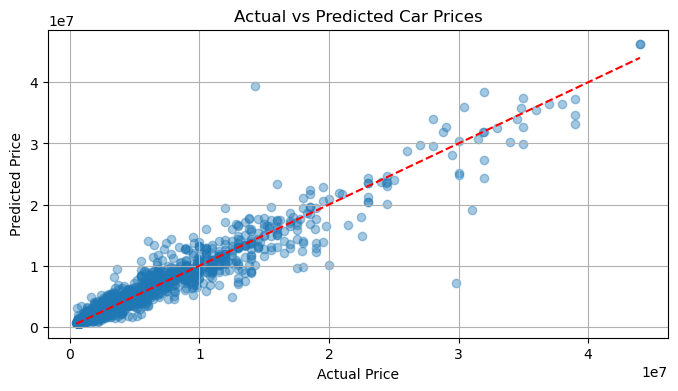

In [12]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True)
plt.show()

##### Plot Residuals

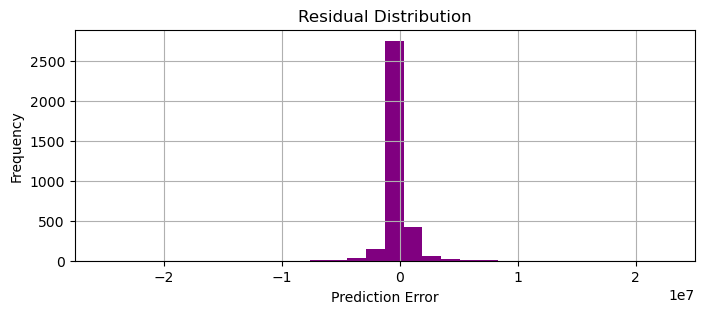

In [13]:
residuals = y_test - y_preds
plt.figure(figsize=(8, 3))
plt.hist(residuals, bins=30, color='purple')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

##### Feature Importance

In [14]:
# importances = model_pipeline.feature_importances_
# features = X.columns
# importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
# importance_df = importance_df.sort_values('Importance', ascending=False)

# print("\n Top 10 Important Features:")
# print(importance_df.head(10))

##### Predicting depreciation using a depreciation curve

In [15]:
def predict_depreciation_curve(make, model_name, base_features, max_age=15):
    predicted_prices = []
    ages = range(1, max_age + 1)

    for age in ages:
        # Create a copy of base features and update it with current age and mileage
        entry = base_features.copy()
        entry.update({
            'make': make,
            'model': model_name,
            'age': age,
            'mileage': 50000 + age * 10000
        })

        # Convert to DataFrame for pipeline input
        temp_df = pd.DataFrame([entry])

        # Directly predict using the pipeline
        pred_price = model_pipeline.predict(temp_df)[0]
        predicted_prices.append(pred_price)

    return ages, predicted_prices


##### Predicting a single output

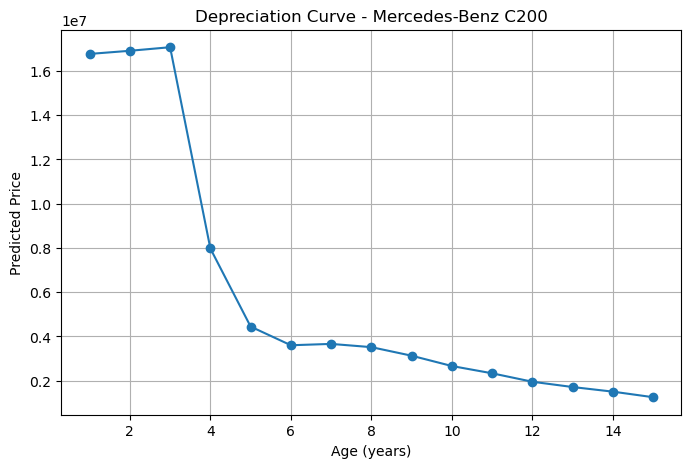

In [16]:
ages, prices = predict_depreciation_curve(
    make='Mercedes-Benz',
    model_name='C200',
    base_features={
        'transmission': 'automatic',
        'color': 'white',
        'previous_ownership': 'foreign used'
    }
)

# Plot depreciation
plt.figure(figsize=(8, 5))
plt.plot(ages, prices, marker='o')
plt.xlabel("Age (years)")
plt.ylabel("Predicted Price")
plt.title("Depreciation Curve - Mercedes-Benz C200")
plt.grid(True)
plt.show()

##### Save the model

In [17]:
joblib.dump(model_pipeline, './predictor-app/model_pipeline.pkl')

['./predictor-app/model_pipeline.pkl']

In [18]:
# Loading the model for use
loaded_model = joblib.load('./predictor-app/model_pipeline.pkl')
loaded_model

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
